# House Price Prediction

SalePrice: - the property's sale price in dollars. This is the target variable that you're trying to predict.

In [1]:
# !pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
# IMPORTS
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras


from keras import metrics
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, ReLU, LeakyReLU, PReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.activations import linear

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# FUNCTIONS
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):
    if batch_size is None:
        batch_size = len(X_train)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    return train_dataset, val_dataset

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

def get_best_epoch_details(history, metric="val_loss", mode=min):
    metric_values = history.history[metric]
    min_metric_value_index = metric_values.index(mode(metric_values))
    best_epoch = min_metric_value_index + 1

    metrics = []
    values = []

    for key, value in history.history.items():
        metrics.append(key)
        values.append(value[min_metric_value_index])

    data = {'Metric': metrics, 'Value': values}
    df = pd.DataFrame(data)
    df['Value'] = df['Value'].map('{:.4f}'.format)
    best_epoch_data = pd.DataFrame({'Metric': ['best_epoch'], 'Value': [str(best_epoch)]})
    df = pd.concat([df, best_epoch_data], ignore_index=True)
    return df

def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

In [11]:
def data_proprocessing(dataframe):

    no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

    for col in no_cols:
        dataframe[col].fillna("No",inplace=True)

    dataframe["NEW_1st*GrLiv"] = dataframe["1stFlrSF"] * dataframe["GrLivArea"]
    dataframe["NEW_Garage*GrLiv"] = (dataframe["GarageArea"] * dataframe["GrLivArea"])
    dataframe["NEW_TotalFlrSF"] = dataframe["1stFlrSF"] + dataframe["2ndFlrSF"]
    dataframe["NEW_TotalBsmtFin"] = dataframe.BsmtFinSF1 + dataframe.BsmtFinSF2
    dataframe["NEW_PorchArea"] = dataframe.OpenPorchSF + dataframe.EnclosedPorch + dataframe.ScreenPorch + dataframe["3SsnPorch"] + dataframe.WoodDeckSF
    dataframe["NEW_TotalHouseArea"] = dataframe.NEW_TotalFlrSF + dataframe.TotalBsmtSF
    dataframe["NEW_TotalSqFeet"] = dataframe.GrLivArea + dataframe.TotalBsmtSF
    dataframe["NEW_LotRatio"] = dataframe.GrLivArea / dataframe.LotArea
    dataframe["NEW_RatioArea"] = dataframe.NEW_TotalHouseArea / dataframe.LotArea
    dataframe["NEW_GarageLotRatio"] = dataframe.GarageArea / dataframe.LotArea
    dataframe["NEW_MasVnrRatio"] = dataframe.MasVnrArea / dataframe.NEW_TotalHouseArea
    dataframe["NEW_DifArea"] = (dataframe.LotArea - dataframe["1stFlrSF"] - dataframe.GarageArea - dataframe.NEW_PorchArea - dataframe.WoodDeckSF)
    dataframe["NEW_OverallGrade"] = dataframe["OverallQual"] * dataframe["OverallCond"]
    dataframe["NEW_Restoration"] = dataframe.YearRemodAdd - dataframe.YearBuilt
    dataframe["NEW_HouseAge"] = dataframe.YrSold - dataframe.YearBuilt
    dataframe["NEW_RestorationAge"] = dataframe.YrSold - dataframe.YearRemodAdd
    dataframe["NEW_GarageAge"] = dataframe.GarageYrBlt - dataframe.YearBuilt
    dataframe["NEW_GarageRestorationAge"] = np.abs(dataframe.GarageYrBlt - dataframe.YearRemodAdd)
    dataframe["NEW_GarageSold"] = dataframe.YrSold - dataframe.GarageYrBlt

    drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood", "Id"]

    dataframe.drop(drop_list, axis=1, inplace=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    num_cols.remove("SalePrice")

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int)

    # We also used 2 types of scalers to avoid falling into Data Leakage (a possible situation that may occur when information
    # about the dependent variable is carried in the independent variable).
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    dataframe[num_cols] = feature_scaler.fit_transform(dataframe[num_cols]) #
    #The most common transformation for the dependent variable in regression problems is Logarithmic. That could also be tried in here.
    dataframe["SalePrice"] = target_scaler.fit_transform(dataframe[["SalePrice"]])

    dump(feature_scaler, 'feature_scaler.joblib')
    dump(target_scaler, 'target_scaler.joblib')

    dataframe.fillna(dataframe.mean(), inplace=True)

    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns]

    y = dataframe["SALEPRICE"]
    X = dataframe.drop(["SALEPRICE"], axis=1)

    return X, y

## Data Prep

In [5]:
df = pd.read_csv("/content/house_prices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.shape

(1460, 81)

In [8]:
X, y = data_proprocessing(df)
X.head()

<ipython-input-6-0b46369e303e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[col].fillna("No",inplace=True)


,MSSUBCLASS,LOTFRONTAGE,LOTAREA,OVERALLQUAL,YEARBUILT,YEARREMODADD,MASVNRAREA,BSMTFINSF1,BSMTFINSF2,BSMTUNFSF,TOTALBSMTSF,1STFLRSF,2NDFLRSF,LOWQUALFINSF,GRLIVAREA,TOTRMSABVGRD,GARAGEYRBLT,GARAGEAREA,WOODDECKSF,OPENPORCHSF,ENCLOSEDPORCH,3SSNPORCH,SCREENPORCH,MISCVAL,MOSOLD,NEW_1ST*GRLIV,NEW_GARAGE*GRLIV,NEW_TOTALFLRSF,NEW_TOTALBSMTFIN,NEW_PORCHAREA,NEW_TOTALHOUSEAREA,NEW_TOTALSQFEET,NEW_LOTRATIO,NEW_RATIOAREA,NEW_GARAGELOTRATIO,NEW_MASVNRRATIO,NEW_DIFAREA,NEW_OVERALLGRADE,NEW_RESTORATION,NEW_HOUSEAGE,NEW_RESTORATIONAGE,NEW_GARAGEAGE,NEW_GARAGERESTORATIONAGE,NEW_GARAGESOLD,MSZONING_FV,MSZONING_RH,MSZONING_RL,MSZONING_RM,LOTSHAPE_IR2,LOTSHAPE_IR3,LOTSHAPE_REG,LOTCONFIG_CULDSAC,LOTCONFIG_FR2,LOTCONFIG_FR3,LOTCONFIG_INSIDE,CONDITION1_FEEDR,CONDITION1_NORM,CONDITION1_POSA,CONDITION1_POSN,CONDITION1_RRAE,CONDITION1_RRAN,CONDITION1_RRNE,CONDITION1_RRNN,CONDITION2_FEEDR,CONDITION2_NORM,CONDITION2_POSA,CONDITION2_POSN,CONDITION2_RRAE,CONDITION2_RRAN,CONDITION2_RRNN,BLDGTYPE_2FMCON,BLDGTYPE_DUPLEX,BLDGTYPE_TWNHS,BLDGTYPE_TWNHSE,HOUSESTYLE_1.5UNF,HOUSESTYLE_1STORY,HOUSESTYLE_2.5FIN,HOUSESTYLE_2.5UNF,HOUSESTYLE_2STORY,HOUSESTYLE_SFOYER,HOUSESTYLE_SLVL,ROOFSTYLE_GABLE,ROOFSTYLE_GAMBREL,ROOFSTYLE_HIP,ROOFSTYLE_MANSARD,ROOFSTYLE_SHED,ROOFMATL_COMPSHG,ROOFMATL_MEMBRAN,ROOFMATL_METAL,ROOFMATL_ROLL,ROOFMATL_TAR&GRV,ROOFMATL_WDSHAKE,ROOFMATL_WDSHNGL,EXTERIOR1ST_ASPHSHN,EXTERIOR1ST_BRKCOMM,EXTERIOR1ST_BRKFACE,EXTERIOR1ST_CBLOCK,EXTERIOR1ST_CEMNTBD,EXTERIOR1ST_HDBOARD,EXTERIOR1ST_IMSTUCC,EXTERIOR1ST_METALSD,EXTERIOR1ST_PLYWOOD,EXTERIOR1ST_STONE,EXTERIOR1ST_STUCCO,EXTERIOR1ST_VINYLSD,EXTERIOR1ST_WD_SDNG,EXTERIOR1ST_WDSHING,EXTERIOR2ND_ASPHSHN,EXTERIOR2ND_BRK_CMN,EXTERIOR2ND_BRKFACE,EXTERIOR2ND_CBLOCK,EXTERIOR2ND_CMENTBD,EXTERIOR2ND_HDBOARD,EXTERIOR2ND_IMSTUCC,EXTERIOR2ND_METALSD,EXTERIOR2ND_OTHER,EXTERIOR2ND_PLYWOOD,EXTERIOR2ND_STONE,EXTERIOR2ND_STUCCO,EXTERIOR2ND_VINYLSD,EXTERIOR2ND_WD_SDNG,EXTERIOR2ND_WD_SHNG,MASVNRTYPE_BRKFACE,MASVNRTYPE_STONE,EXTERQUAL_FA,EXTERQUAL_GD,EXTERQUAL_TA,EXTERCOND_FA,EXTERCOND_GD,EXTERCOND_PO,EXTERCOND_TA,FOUNDATION_CBLOCK,FOUNDATION_PCONC,FOUNDATION_SLAB,FOUNDATION_STONE,FOUNDATION_WOOD,BSMTQUAL_FA,BSMTQUAL_GD,BSMTQUAL_NO,BSMTQUAL_TA,BSMTCOND_GD,BSMTCOND_NO,BSMTCOND_PO,BSMTCOND_TA,BSMTEXPOSURE_GD,BSMTEXPOSURE_MN,BSMTEXPOSURE_NO,BSMTFINTYPE1_BLQ,BSMTFINTYPE1_GLQ,BSMTFINTYPE1_LWQ,BSMTFINTYPE1_NO,BSMTFINTYPE1_REC,BSMTFINTYPE1_UNF,BSMTFINTYPE2_BLQ,BSMTFINTYPE2_GLQ,BSMTFINTYPE2_LWQ,BSMTFINTYPE2_NO,BSMTFINTYPE2_REC,BSMTFINTYPE2_UNF,HEATINGQC_FA,HEATINGQC_GD,HEATINGQC_PO,HEATINGQC_TA,CENTRALAIR_Y,ELECTRICAL_FUSEF,ELECTRICAL_FUSEP,ELECTRICAL_MIX,ELECTRICAL_SBRKR,KITCHENQUAL_FA,KITCHENQUAL_GD,KITCHENQUAL_TA,FUNCTIONAL_MAJ2,FUNCTIONAL_MIN1,FUNCTIONAL_MIN2,FUNCTIONAL_MOD,FUNCTIONAL_SEV,FUNCTIONAL_TYP,FIREPLACEQU_FA,FIREPLACEQU_GD,FIREPLACEQU_NO,FIREPLACEQU_PO,FIREPLACEQU_TA,GARAGETYPE_ATTCHD,GARAGETYPE_BASMENT,GARAGETYPE_BUILTIN,GARAGETYPE_CARPORT,GARAGETYPE_DETCHD,GARAGETYPE_NO,GARAGEFINISH_NO,GARAGEFINISH_RFN,GARAGEFINISH_UNF,GARAGEQUAL_FA,GARAGEQUAL_GD,GARAGEQUAL_NO,GARAGEQUAL_PO,GARAGEQUAL_TA,GARAGECOND_FA,GARAGECOND_GD,GARAGECOND_NO,GARAGECOND_PO,GARAGECOND_TA,PAVEDDRIVE_P,PAVEDDRIVE_Y,FENCE_GDWO,FENCE_MNPRV,FENCE_MNWW,FENCE_NO,SALETYPE_CWD,SALETYPE_CON,SALETYPE_CONLD,SALETYPE_CONLI,SALETYPE_CONLW,SALETYPE_NEW,SALETYPE_OTH,SALETYPE_WD,SALECONDITION_ADJLAND,SALECONDITION_ALLOCA,SALECONDITION_FAMILY,SALECONDITION_NORMAL,SALECONDITION_PARTIAL,OVERALLCOND_2,OVERALLCOND_3,OVERALLCOND_4,OVERALLCOND_5,OVERALLCOND_6,OVERALLCOND_7,OVERALLCOND_8,OVERALLCOND_9,BSMTFULLBATH_1,BSMTFULLBATH_2,BSMTFULLBATH_3,BSMTHALFBATH_1,BSMTHALFBATH_2,FULLBATH_1,FULLBATH_2,FULLBATH_3,HALFBATH_1,HALFBATH_2,BEDROOMABVGR_1,BEDROOMABVGR_2,BEDROOMABVGR_3,BEDROOMABVGR_4,BEDROOMABVGR_5,BEDROOMABVGR_6,BEDROOMABVGR_8,KITCHENABVGR_1,KITCHENABVGR_2,KITCHENABVGR_3,FIREPLACES_1,FIREPLACES_2,FIREPLACES_3,GARAGECARS_1,GARAGECARS_2,GARAGECARS_3,GARAGECARS_4,POOLAREA_480,POOLAREA_512,POOLAREA_519,POOLAREA_555,POOLAREA_576,POOLAREA_648,POOLAREA_738,YRSOLD_2007,YRSOLD_20

In [9]:
X.shape

(1460, 266)

In [10]:
y.head()

,SALEPRICE
0,0.24108
1,0.20358
2,0.26191
3,0.14595
4,0.29871


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val, batch_size=32)

## Modeling

In [13]:
base_model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),

    BatchNormalization(),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),

    BatchNormalization(),

    Dense(1, activation='linear')])

In [17]:
optimizer = Adam(learning_rate=0.001)

base_model.compile(

    optimizer=optimizer,

    loss='mse', #we can use logloss func, but it is more appropriate to use "mean square error" for regression problems!

    metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()]
)

In [15]:
early_stopping = EarlyStopping(

    monitor='val_mean_squared_error', # We also adjusted our monitor metric because here is a regression problem.

    patience=100,

    verbose=1,

    restore_best_weights=True,

    mode="min"
)

In [16]:
base_model_history = base_model.fit(train_ds,

                                    epochs=1000,

                                    validation_data=val_ds,

                                    verbose=1,

                                    callbacks=early_stopping)

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.6999 - mean_absolute_error: 0.9973 - mean_squared_error: 1.6495 - root_mean_squared_error: 1.2755 - val_loss: 0.0838 - val_mean_absolute_error: 0.1529 - val_mean_squared_error: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4027 - mean_absolute_error: 0.4458 - mean_squared_error: 0.3549 - root_mean_squared_error: 0.5949 - val_loss: 0.0864 - val_mean_absolute_error: 0.1637 - val_mean_squared_error: 0.0394 - val_root_mean_squared_error: 0.1985
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2561 - mean_absolute_error: 0.3500 - mean_squared_error: 0.2093 - root_mean_squared_error: 0.4569 - val_loss: 0.0907 - val_mean_absolute_error: 0.1733 - val_mean_squared_error: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1955 - mean_absolute_error: 0.2909 - mean_squared_error: 0.1491 - root_mean_squared_er

In [18]:
get_best_epoch_details(base_model_history, metric="val_mean_squared_error", mode=min)

,Metric,Value
0,loss,0.0019
1,mean_absolute_error,0.0279
2,mean_squared_error,0.0014
3,root_mean_squared_error,0.0374
4,val_loss,0.0019
5,val_mean_absolute_error,0.0260
6,val_mean_squared_error,0.0014
7,val_root_mean_squared_error,0.0376
8,best_epoch,287


In [19]:
val_loss, val_mse, val_rmse, val_mae = base_model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")

Validation Loss: 0.0019432702101767063
Validation MSE: 0.001414725324138999
Validation RMSE: 0.037612833082675934
Validation MAE: 0.025989172980189323


In [20]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │           4,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,041 (19.69 KB)

 Trainable params: 4,945 (19.32 KB)

 Non-trainable params: 96 (384.00 B)

In [21]:
# I have inversed "Predictions and Actual Values" to translate our success into a more understandable format.

## Inverse Predictions

In [22]:
feature_scaler = load('/content/feature_scaler.joblib')

target_scaler = load('/content/target_scaler.joblib')

In [26]:
# Since Estimation and Actual values are scaled, they are made Inverse.
# The model is called and asked for features, the model makes predictions for the features, then these predictions are reversed. 
# Similarly, actual values are called and inverted.
def evaluate_inverse(val_ds, model, scaler):
    predictions = []
    true_values = []

    # val_ds => my data as tensorflow dataset
    for features, labels in val_ds:
        batch_predictions = model.predict(features, verbose=0)

        predictions.extend(batch_predictions.flatten()) # flatten() => vectorization process

        true_values.extend(labels.numpy().flatten())


    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # inverse_transform() => Estimates and Actual Values have become understandable here with inverse_scale.
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    true_values = scaler.inverse_transform(true_values.reshape(-1, 1))

    # Error metrics are calculated!
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)

    print(f"Mean Squared Error: {mse}")
    # It would be more accurate and understandable to examine RMSE and MAE when evaluating real values!
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")

    # If the Dependent (Target) Variable is Numeric, print the parameters that can be evaluated!
    print("y_true_mean:", true_values.mean()) # Average value of houses in $. 
    print("y_true_std:", true_values.std())

# function call
evaluate_inverse(val_ds, base_model, target_scaler)

Mean Squared Error: 733597420.5515878
Root Mean Squared Error: 27085.003609960768
Mean Absolute Error: 18714.80363067209
y_true_mean: 178839.81164383562
y_true_std: 87580.39853293159


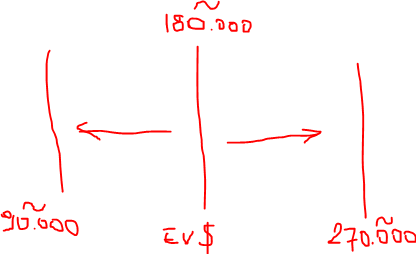

## Hyperparameter Optimization

In [27]:
df = pd.read_csv("/content/house_prices.csv")

X, y = data_proprocessing(df)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val, batch_size=32)

<ipython-input-11-d805bb035671>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[col].fillna("No",inplace=True)


In [28]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    # Hidden layers with advanced activation functions, l2, Dropout
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(Dense(
            units=hp.Int('units_' + str(i + 1), min_value=32, max_value=512, step=16),
            kernel_regularizer=l2(hp.Float('l2_' + str(i + 1), min_value=0.0001, max_value=0.01, sampling='log'))
        ))

        # Activation layer choice
        activation_choice = hp.Choice('activation_' + str(i + 1), values=['relu', 'leaky_relu', 'prelu'])

        if activation_choice == 'relu':
            model.add(ReLU())
        elif activation_choice == 'leaky_relu':
            model.add(LeakyReLU(negative_slope=0.01))
        elif activation_choice == 'prelu':
            model.add(PReLU())

        model.add(BatchNormalization())

        model.add(Dropout(hp.Float('dropout_' + str(i + 1), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer with linear activation for regression
    model.add(Dense(1, activation='linear'))

    # Optimizer: Adam with tuning for beta1 and beta2
    optimizer = Adam(
        beta_1=hp.Float('beta1', min_value=0.85, max_value=0.99, step=0.01),
        beta_2=hp.Float('beta2', min_value=0.995, max_value=0.999, step=0.001)
    )

    # Compile the model with mean squared error loss for regression
    model.compile(optimizer=optimizer,
                  loss="mse",
                  metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [29]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    # max_trials=30,
    max_trials=10,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_mean_squared_error',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'final_tuned_house_price_model.keras',
    monitor='val_mean_squared_error',
    verbose=0,
    save_best_only=True)


random_search_tuner.search(
    train_ds,
    # epochs=200,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]
)

Trial 10 Complete [00h 00m 40s]
val_mean_squared_error: 0.004277035128325224

Best val_mean_squared_error So Far: 0.003299514763057232
Total elapsed time: 00h 07m 17s


In [30]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

print_hyperparameters(best_hps.values)

   Hyperparameter       Value
0      num_layers           7
1         units_1         464
2            l2_1     0.00373
3    activation_1  leaky_relu
4       dropout_1     0.20000
5           beta1     0.86000
6           beta2     0.99700
7         units_2         176
8            l2_2     0.00135
9    activation_2       prelu
10      dropout_2     0.00000
11        units_3         288
12           l2_3     0.00065
13   activation_3        relu
14      dropout_3     0.00000
15        units_4         336
16           l2_4     0.00017
17   activation_4       prelu
18      dropout_4     0.30000
19        units_5         224
20           l2_5     0.00114
21   activation_5  leaky_relu
22      dropout_5     0.10000
23        units_6         176
24           l2_6     0.00934
25   activation_6  leaky_relu
26      dropout_6     0.40000
27        units_7         320
28           l2_7     0.00045
29   activation_7       prelu
30      dropout_7     0.40000
31        units_8         256
32        

In [31]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 68 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 464)                 │         123,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 464)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 464)                 │           1,856 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 464)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 176)                 │          81,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu (PReLU)                      │ (None, 176)                 │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 176)                 │             704 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 288)                 │          50,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 288)                 │           1,152 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 336)                 │          97,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_1 (PReLU)                    │ (None, 336)                 │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 336)                 │           1,344 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 336)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 224)                 │          75,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224)                 │             896 │
│ (BatchNormalization)                 │                             │              

 Total params: 534,625 (2.04 MB)

 Trainable params: 530,657 (2.02 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [32]:
val_loss, val_mse, val_rmse, val_mae = best_model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")

Validation Loss: 0.7457603812217712
Validation MSE: 0.003299514763057232
Validation RMSE: 0.05744140222668648
Validation MAE: 0.04090801253914833


In [33]:
evaluate_inverse(val_ds, best_model, target_scaler)

Mean Squared Error: 1710943600.6354926
Root Mean Squared Error: 41363.554013593806
Mean Absolute Error: 29457.8595020869
y_true_mean: 178839.81164383562
y_true_std: 87580.39853293159


## Error Analysis

***NOTE*** : When it comes to regression problems, we do not only examine the metrics, we generally deepen our evaluations by doing "Error Analysis". This is the part where we look for answers to the question of what are the reasons for our erroneous predictions!!

In [34]:
from sklearn.metrics import r2_score

#### R2 Value: It is one of the indicators that show the performance of a regression problem. In Classification Problems, we had the Accuracy value and determined our success accordingly. **R2_score** => It shows how well the independent variables in the model explain the variance value in the dependent variable. It takes values between (0,1) and the higher the better. For example: 0.75 => indicates that we can explain 75% of the target variable with the existing variables we have.

In [37]:
# We discuss the difference between Actual Values and Estimated Values in more detail!
def evaluate_inverse(val_ds, model, scaler):
    predictions = []
    true_values = []

    for features, labels in val_ds:

        batch_predictions = model.predict(features, verbose=0)

        predictions.extend(batch_predictions.flatten())

        true_values.extend(labels.numpy().flatten())

    predictions = np.array(predictions)

    true_values = np.array(true_values)

    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    true_values = scaler.inverse_transform(true_values.reshape(-1, 1))

    mse = mean_squared_error(true_values, predictions)

    rmse = np.sqrt(mse)

    mae = mean_absolute_error(true_values, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")

    print("y_true_mean:", true_values.mean())
    print("y_true_std:", true_values.std())

    return true_values, predictions

In [38]:
true_values, predictions = evaluate_inverse(val_ds, best_model, target_scaler)

Mean Squared Error: 1710943600.6354926
Root Mean Squared Error: 41363.554013593806
Mean Absolute Error: 29457.8595020869
y_true_mean: 178839.81164383562
y_true_std: 87580.39853293159


In [39]:
def analyze_predictions(true_values, predictions):
    true_values = true_values.ravel()
    predictions = predictions.ravel()

    true_series = pd.Series(true_values, name="True Values")
    pred_series = pd.Series(predictions, name="Predictions")

    statistics = pd.DataFrame([true_series.describe(), pred_series.describe()])
    print("Basic Statistics:\n", statistics)

    # metrics
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    print("")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")

    # distribution graphs
    plt.figure(figsize=(12, 12))

    # Histogram
    plt.subplot(2, 1, 1)
    sns.histplot(true_values, kde=True, color='blue', label='True Values')
    sns.histplot(predictions, kde=True, color='orange', label='Predictions')
    plt.legend()
    plt.title('Histogram')

    # Scatter Plot
    plt.subplot(2, 1, 2)
    sns.scatterplot(x=true_values, y=predictions)
    plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Scatter Plot')

    plt.tight_layout()
    plt.show()

    # error analysis
    residuals = true_values - predictions
    plt.figure(figsize=(12, 12))

    # distribution of errors
    plt.subplot(2, 1, 1)
    sns.histplot(residuals, kde=True, color='red')
    plt.title('Residuals Distribution')

    plt.tight_layout()
    plt.show()

Basic Statistics:
                 count         mean         std         min          25%  \
True Values 292.00000 178839.81164 87730.75126 35311.00000 127000.00000   
Predictions 292.00000 161964.56250 78937.11719 31097.56836 110058.68555   

                     50%          75%          max  
True Values 154150.00000 209175.00000 755000.00000  
Predictions 141350.92969 192338.03516 543122.25000  

Mean Absolute Error (MAE): 29457.8595020869
Mean Squared Error (MSE): 1710943600.6354926
Root Mean Squared Error (RMSE): 41363.554013593806
R-squared (R²): 0.7769399169708934


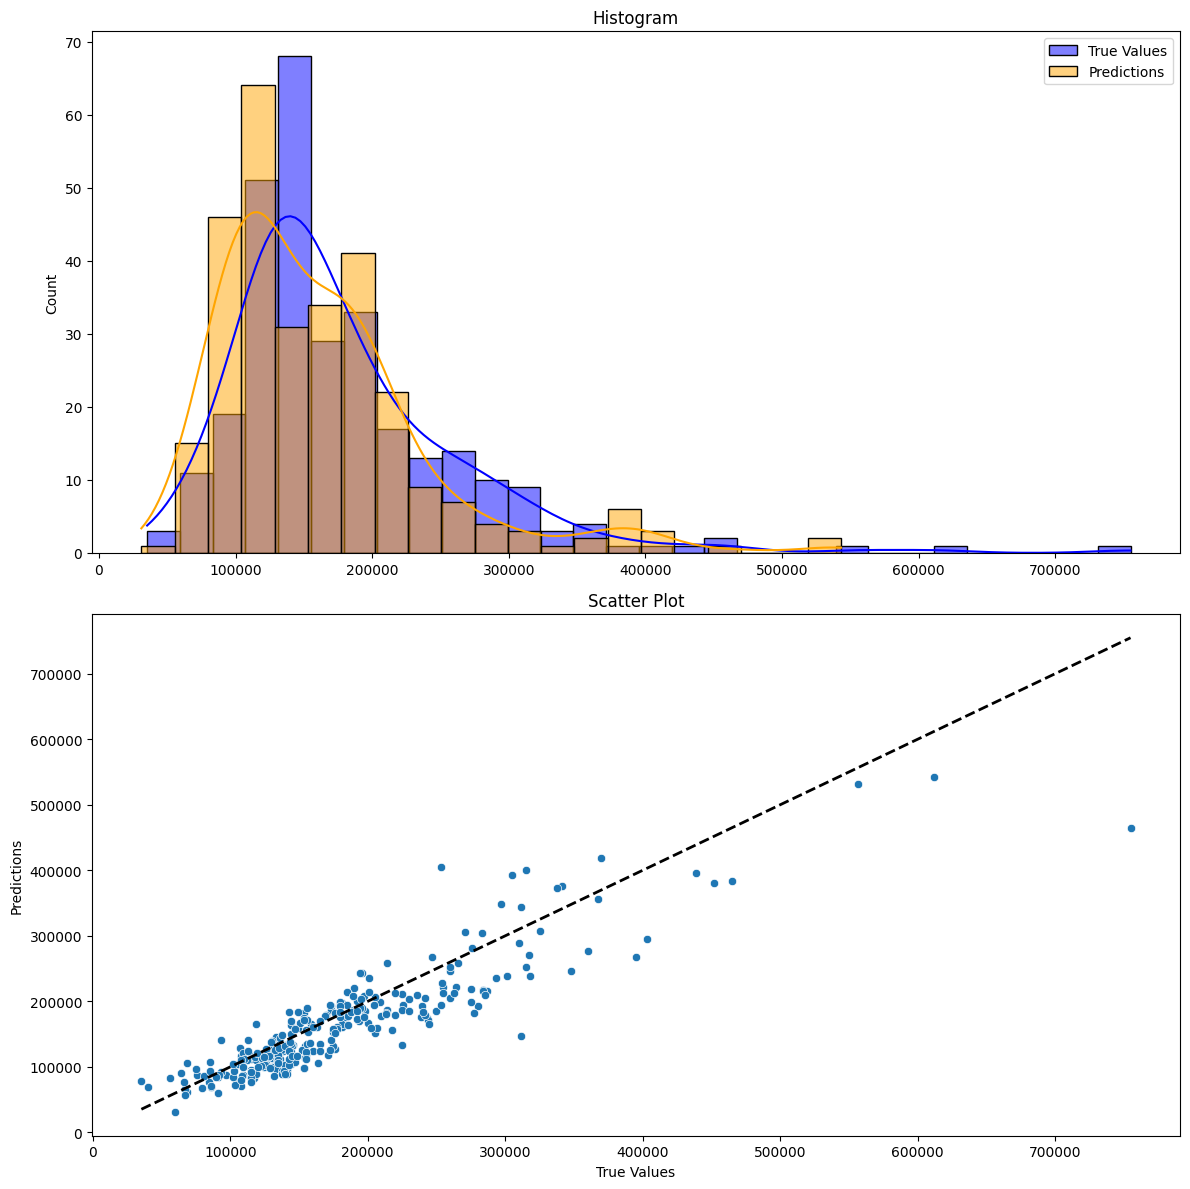

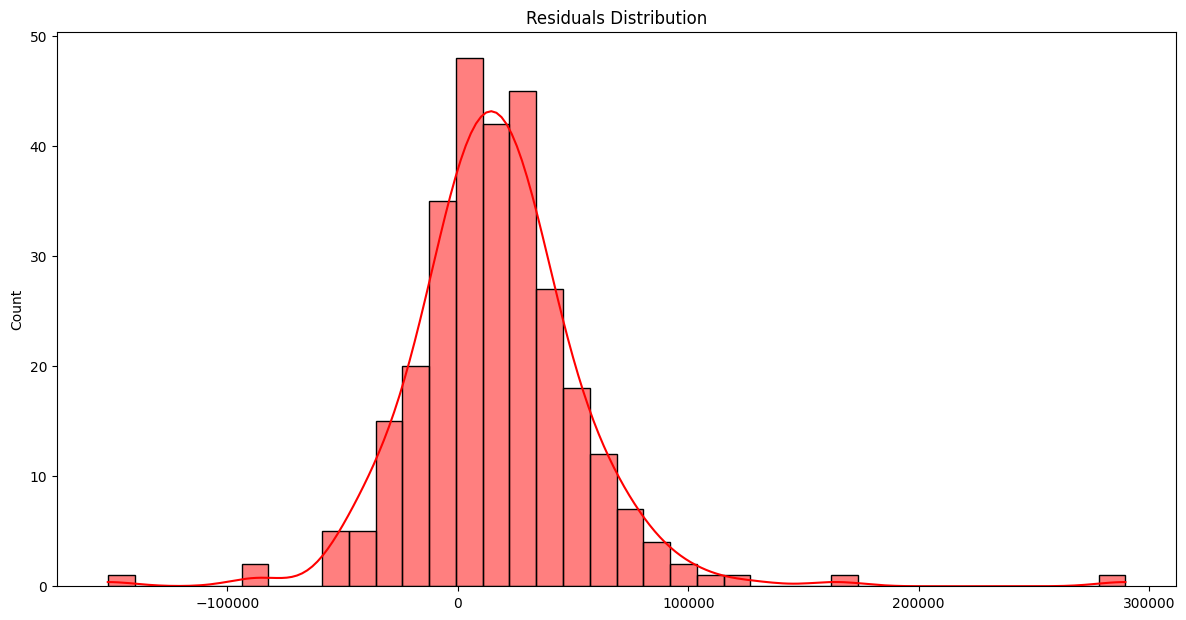

In [40]:
analyze_predictions(true_values, predictions)

In [1]:
# Brown areas in the histogram => Places where actual and forecast overlap.
# In the Scatter Plot, points close to the dashed line indicate very good predictions, points further away indicate bad predictions.
# Residual Dist => It is the scatter plot of the Errors of the model.From this graph, the error distribution is expected to be approximately normal distribution. 
# This is because we expect the expected value of the actual values and the predicted values to be 0.
# The fact that the center is close to 0 indicates that the model makes bias-free predictions. We understand that the predictions do not contain an erroneous pattern.
# It also means that the errors are distributed randomly.If we are still not satisfied, we continue to deepen our analysis on quarters.

### Performance by percentiles

In [42]:
def analyze_predictions_by_percentiles(true_values, predictions, percentiles=[5, 25, 50, 75, 95, 100]):
    true_values = true_values.ravel()
    predictions = predictions.ravel()

    # Calculate residuals
    residuals = np.abs(true_values - predictions)

    # Combine true values, predictions, and residuals into a DataFrame
    df = pd.DataFrame({
        'True Values': true_values,
        'Predictions': predictions,
        'Residuals': residuals
    })

    # Calculate and print performance metrics for the specified percentiles
    performance_by_percentile = {}
    for percentile in percentiles:
        threshold = np.percentile(df['Residuals'], percentile)
        within_threshold = df[df['Residuals'] <= threshold]
        mae = mean_absolute_error(within_threshold['True Values'], within_threshold['Predictions'])
        mse = mean_squared_error(within_threshold['True Values'], within_threshold['Predictions'])
        rmse = np.sqrt(mse)
        r2 = r2_score(within_threshold['True Values'], within_threshold['Predictions'])

        performance_by_percentile[percentile] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }

    # Print performance by percentile
    for percentile, metrics in performance_by_percentile.items():
        print(f"Performance for {percentile}th Percentile:")
        print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
        print(f"  Mean Squared Error (MSE): {metrics['MSE']}")
        print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']}")
        print(f"  R-squared (R²): {metrics['R2']}")
        print()

    return performance_by_percentile


performance_by_percentile = analyze_predictions_by_percentiles(true_values, predictions)

Performance for 5th Percentile:
  Mean Absolute Error (MAE): 1037.6651041666657
  Mean Squared Error (MSE): 1363994.93436279
  Root Mean Squared Error (RMSE): 1167.9019369633695
  R-squared (R²): 0.9984487925241347

Performance for 25th Percentile:
  Mean Absolute Error (MAE): 5468.832887414384
  Mean Squared Error (MSE): 39144015.34370171
  Root Mean Squared Error (RMSE): 6256.517828928621
  R-squared (R²): 0.9808871283459906

Performance for 50th Percentile:
  Mean Absolute Error (MAE): 10903.83195098459
  Mean Squared Error (MSE): 160927545.89264303
  Root Mean Squared Error (RMSE): 12685.722127362045
  R-squared (R²): 0.9388848933891153

Performance for 75th Percentile:
  Mean Absolute Error (MAE): 17427.703793878427
  Mean Squared Error (MSE): 423927942.92012143
  Root Mean Squared Error (RMSE): 20589.510507054834
  R-squared (R²): 0.8856216086138694

Performance for 95th Percentile:
  Mean Absolute Error (MAE): 24872.469955719764
  Mean Squared Error (MSE): 944166099.1816111
  Ro

In [43]:
residuals = true_values - predictions

threshold = 2 * np.std(residuals)

outlier_indices = np.where(np.abs(residuals) > threshold)[0]

outliers = pd.DataFrame({
        'True Values': true_values[outlier_indices].flatten(),
        'Predictions': predictions[outlier_indices].flatten(),
        'Residuals': residuals[outlier_indices].flatten()})


outliers

,True Values,Predictions,Residuals
0,315500.00000,399754.53125,-84254.53125
1,311500.00000,147317.32812,164182.67188
2,253293.00000,405246.46875,-151953.46875
3,305000.00000,393634.50000,-88634.50000
4,348000.00000,246129.68750,101870.31250
5,755000.00000,465313.71875,289686.28125
6,403000.00000,295932.75000,107067.25000
7,244400.00000,165400.32812,78999.67188
8,360000.00000,276483.28125,83516.71875
9,225000.00000,133116.87500,91883.12500


In [2]:
# Here are suggestions to increase the success of the model;
# 1. Using logarithmic transform
# 2. Deleting or suppressing outliers at the beginning of the study